In [1]:
import numpy as np
import cvxpy as cvx
from numpy.random import randn
import matplotlib.pyplot as plt
%matplotlib inline

# Problem 1

In [2]:
n = 20
M = 25
K = 100
np.random.seed(1)
c_true = randn(n)
X  = randn(n,K)
y = np.dot(X.T, c_true) + 0.1 * np.sqrt(n) * randn(K)
print(c_true.shape)

(20,)


In [3]:
sort_ind = np.argsort(y)
X = X[:, sort_ind]
y = y[sort_ind[:M+1]]
D = (y[M-1] + y[M])/2
y = y[:M,np.newaxis]

Very simple treatment: about points X[:,M:] we know only that $y_i$ should be $y_i \geq D$, so let's have constraint $c^\top x_i \geq D, i > M$ and minimize by X[:,:M] part of X.
$$
\min_{X} c^\top X_{i \leq M}, \\
c^\top X_{i > M} \geq D
$$

In [4]:
c = cvx.Variable(n)
constraints = [c.T*X[:,M:] >= D] # our X[:,M:] is this part with censored values for y

In [5]:
obj = cvx.Minimize(cvx.sum_squares(c.T*X[:,:M]-y.T)) # and minimize by known y

In [6]:
prob = cvx.Problem(obj, constraints) #usual routine

In [7]:
prob = cvx.Problem(obj, constraints)
prob.solve()  
print ("status:", prob.status)
print ("optimal value %.7f" % (prob.value))
print(c.value)

status: optimal
optimal value 2.0711948
[[ 1.53817956]
 [-0.75310014]
 [-0.43716121]
 [-1.04458413]
 [ 0.87371472]
 [-2.28535139]
 [ 1.79176345]
 [-0.71101112]
 [ 0.2644144 ]
 [-0.30984617]
 [ 1.43450893]
 [-2.115688  ]
 [-0.35096751]
 [-0.37592943]
 [ 1.18146074]
 [-1.1473156 ]
 [-0.04681776]
 [-1.14158709]
 [ 0.13219842]
 [ 0.54257486]]


In [8]:
c_true

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038,
        1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
       -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521])

In [9]:
def compare(c1, c_true): #calculation of suggested relative error metric
    return np.sqrt(np.sum((np.squeeze(np.asarray(c1))-c_true)**2)/np.sum(c_true**2))

In [10]:
print(compare(c.value, c_true))

0.0788161641764


In [11]:
prob2 = cvx.Problem(obj, []) # now we just remove constraints about i >= M points, that's means we just minimize by first known points
prob2.solve()  
print ("status:", prob2.status)
print ("optimal value %.7f" % (prob2.value))
print(compare(c.value, c_true))

status: optimal
optimal value 0.9040512
0.227096701662


# Problem 2

In [12]:
import scipy.io as sio

mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a'][0,0]
b = mat_contents['b'][0,0]
c = mat_contents['c'][0,0]
d = mat_contents['d'].squeeze()
n = mat_contents['n'][0,0]
smin = mat_contents['smin'].squeeze()
smax = mat_contents['smax'].squeeze()
tau_min = mat_contents['tau_min'].squeeze()
tau_max = mat_contents['tau_max'].squeeze()


Let's save build a good function of vector $\vec{t}$. If $t_i$ is time of arrival at $i$ position, that's obvious to write constraints, but our function to minimize will contain $\frac{1}{t_i - t_{i-1}}$. Let's get rid of this and denote $t_i$ to time of travel through $d_i$. Our $f(\vec{t})$ is $\sum g(t_i)$, where $g$ is convex (linear combination of convex $1/t$ on $t>0$, $const$ and $t$), so, $f$ is convex.
$$\min_{t}\sum_i \left( \frac{a}{t_i}d_i^2 + b d_i + c t_i \right),\\
\tau^{min}_i \leq \sum_{j=0}^{i} t_j \leq \tau^{max}_i, \\
s^{min}_i t_i \leq d_i, \\
s^{max}_i t_i \geq d_i 
$$


In [20]:
t = cvx.Variable(n)
A = np.tril(np.ones((n,n)))
constraints = [
    A*t <= tau_max, A*t >= tau_min,
    cvx.mul_elemwise(smin,t) <= d,
    cvx.mul_elemwise(smax,t) >= d
]
d2 = d**2
obj = cvx.Minimize(cvx.sum_entries(a*cvx.mul_elemwise(d2,cvx.inv_pos(t)) + b*d + c*t))

In [21]:
prob = cvx.Problem(obj, constraints)
prob.solve()  
print ("status:", prob.status)
print ("optimal value %.7f" % (prob.value))

status: optimal
optimal value 2617.8251935


(100, 1) (100, 1) (100, 1)


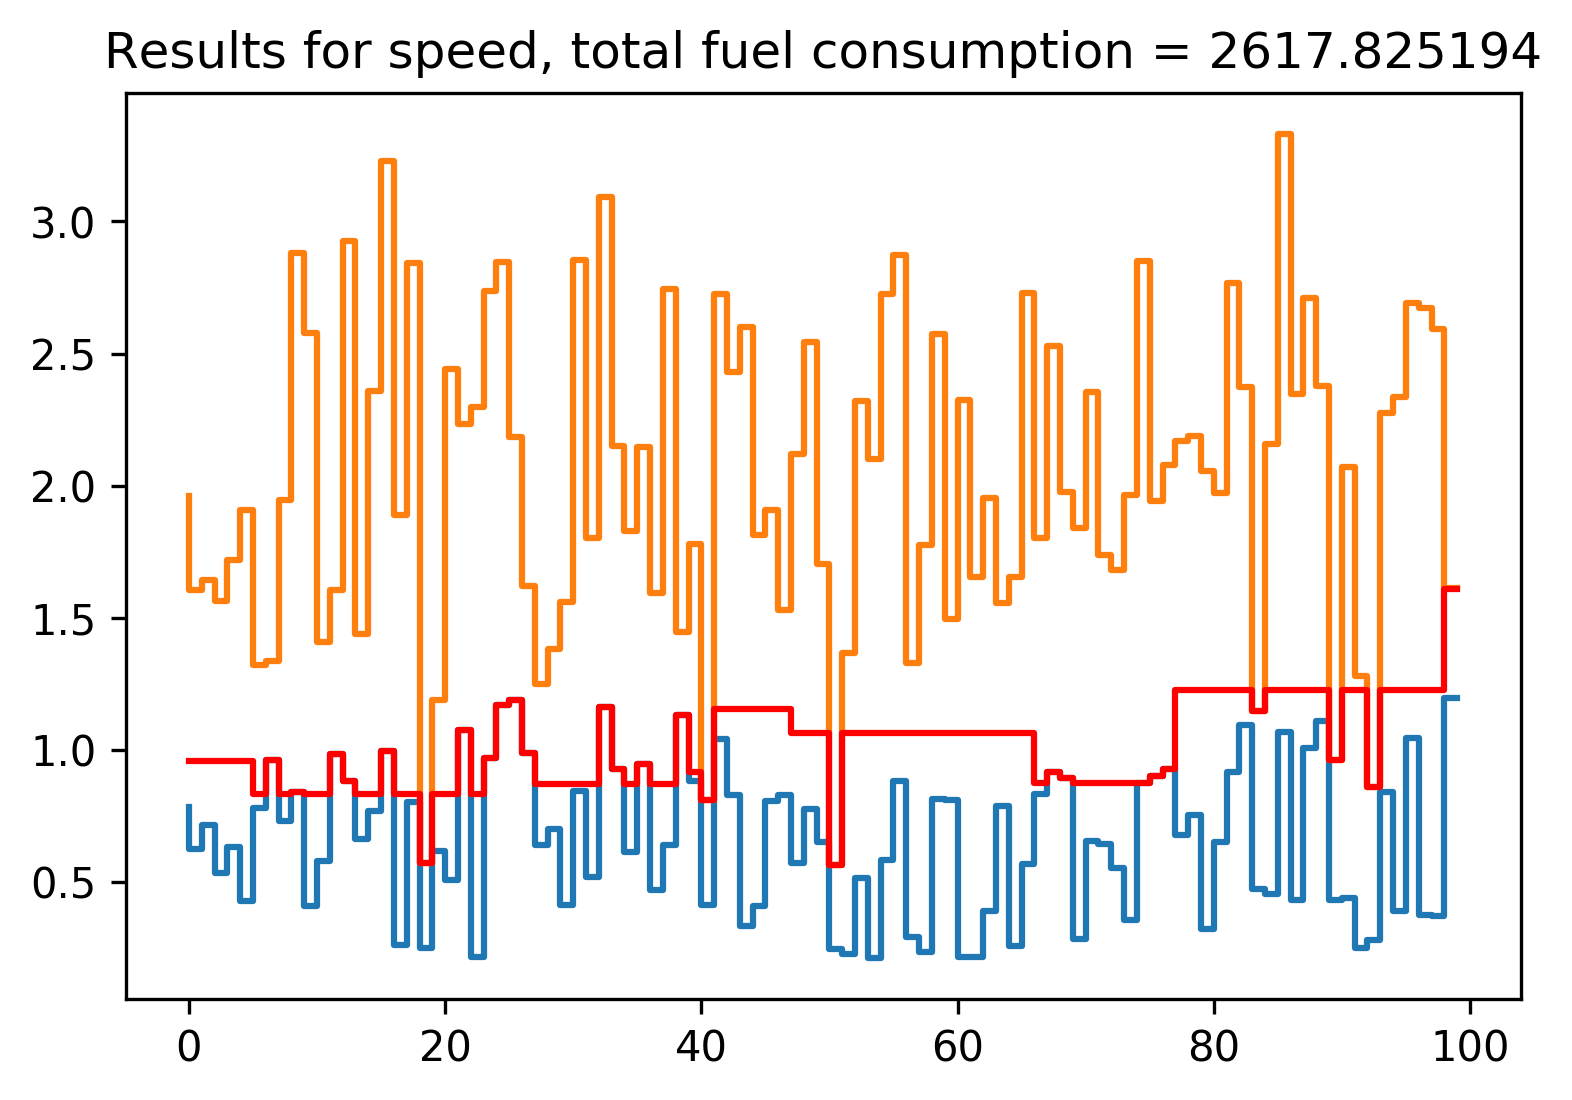

In [22]:
speeds = np.divide(d[:,np.newaxis],t.value)
print(speeds.shape, d[:,np.newaxis].shape, t.value.shape)
fig, ax = plt.subplots(figsize=(6,4), dpi=300)
ax.set_title('Results for speed, total fuel consumption = %f'%(prob.value))
ax.step(list(range(n)), smin)
ax.step(list(range(n)), smax)
ax.step(list(range(n)), speeds, 'r-')

# Problem 7

### Primal

In [23]:
W = np.matrix([[2,-1/2],[-1/2,2]])
C = np.matrix([[2,3],[4,5]])
x = cvx.Variable(2)
primal_obj = cvx.Minimize(cvx.quad_form(x,W))
primal_constraints = [
    C*x >= 1
]
primal_prob = cvx.Problem(primal_obj,primal_constraints)
primal_prob.solve()  
print ("status:", primal_prob.status)
print ("optimal value %.7f" % (primal_prob.value))

status: optimal
optimal value 0.1171875


### Dual

$$ L(x,\lambda) = x^\top W x - \lambda_1 (2x_1 + 3x_2) - \lambda_2 (4x_1 + 5x_2) + \lambda_1 + \lambda_2 $$
To minimize by x we should $\nabla_x L = 0$ (because differentiable).


We need then to find $g(\lambda)$ by $\min_x L(x,\lambda)$. For that we need to $\nabla_x L = 0$. Let's do it with sympy.
Than with cvxpy we maximize $g(\lambda)$ over $\lambda \geq 0$.

In [24]:
import sympy as sp

In [25]:
x1,x2,l1,l2 = sp.symbols('x1 x2 l1 l2')

In [27]:
L = 2*x1*x1 + 2*x2*x2 - x1*x2 - l1*(2*x1+3*x2) - l2*(4*x1+5*x2) + l1 + l2

In [40]:
sp.solve([sp.diff(L,x1),sp.diff(L,x2)],x1,x2)

{x1: 11*l1/15 + 7*l2/5, x2: 14*l1/15 + 8*l2/5}

In [41]:
g = L.subs(x1,11*l1/15 + 7*l2/5).subs(x2,14*l1/15 + 8*l2/5)

In [42]:
g.simplify()

-32*l1**2/15 - 38*l1*l2/5 + l1 - 34*l2**2/5 + l2

In [44]:
λ = cvx.Variable(2)
W2 = np.matrix([[-32/15, -19/5],[-19/5,-34/5]])
dual_objective = cvx.Maximize(cvx.quad_form(λ,W2) + cvx.sum_entries(λ))
dual_constraints = [
    λ >= 0
]
dual_prob = cvx.Problem(dual_objective,dual_constraints)
dual_prob.solve()  
print ("status:", dual_prob.status)
print ("optimal value %.7f" % (dual_prob.value))

status: optimal
optimal value 0.1171875


So, optimal values are the same :)